In [2]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install ipywidgets


In [4]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from DataAugmentation_Unlabelled import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
from data_utils_unlabelled import loadUnlabelledDatafromFile,createTokenizedDfUnlabelled,CompDatasetUnlabelled
from seqeval.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef,classification_report,f1_score
import engine
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import random

In [5]:
# config = reload(config)

In [4]:
# Read the data
def process_data(filePath_src,filePath_tar,model_type):
    
    dataObj = loadUnlabelledDatafromFile(filePath_src,filePath_tar)
    df= dataObj.createDfUnlabelled() # get dataframe from files
    df['len_src'] = df['source'].str.split().map(lambda x:len(x))
    df['len_tar'] = df['target'].str.split().map(lambda x:len(x))
    
    df = df[df.len_tar != 36]
    df = df[df.len_tar != 2]
    df = df[df.len_src != 1]
    
    df=df.iloc[:,:-2]
    obj_tokenized = createTokenizedDfUnlabelled(df,model_type)
    df_new= obj_tokenized.convertDf()
#     enc_label = preprocessing.LabelEncoder()
#     df_new['labels']= enc_label.fit_transform(df_new['labels'])
    train_data = CompDatasetUnlabelled(df_new,model_type)
    return train_data,df,df_new


In [5]:
dataset_train,df,df_new = process_data(config.filePath_src_backtranslated,config.filePath_tar_backtranslated,model_type = 'xlm')
len(dataset_train)

6997

In [5]:
def process_data_eval(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,model_type):
    
    dataObj = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df= dataObj.createDf() # get dataframe from files
    obj_tokenized = createTokenizedDf(df,model_type)
    df_new= obj_tokenized.convertDf()
    
    val_data = CompDataset(df_new,model_type)
    return val_data,df,df_new

In [6]:
# dataset_eval,df,df_new = process_data_eval(config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval,model_type = 'xlm')
# len(dataset_eval)
dataset_train,df_train,df_new_train = process_data_eval(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags,model_type = 'xlm')
len(dataset_train)

7000

In [8]:
df_new_train

,sentence_id,words,labels
0,0,▁José,1
1,0,▁Ort,1
2,0,ega,1
3,0,▁y,1
4,0,▁G,1
...,...,...,...
510514,6999,का,1
510515,6999,▁,1
510516,6999,.,1
510517,6999,का,1


In [9]:
# df['len_src'] = df['source'].str.split().map(lambda x:len(x))
# df['len_tar'] = df['target'].str.split().map(lambda x:len(x))
# print('Source : Max length: {}, Min length: {}, Average Length :  {}'.format(max(df['len_src']),min(df['len_src']),df['len_src'].mean()))
# print('Source : Max length: {}, Min length: {}, Average Length :  {}'.format(max(df['len_tar']),min(df['len_tar']),df['len_tar'].mean()))
# new = df_new.groupby('sentence_id')
# new
new_df = df_new_train.iloc[:,:-1].groupby('sentence_id')['words'].count().reset_index(name="countofwords")
# print(new_df[new_df.words > 128])
new_df[new_df.countofwords>128]
# d=df1.groupby(['col1','col2'])['col2'].count()

,sentence_id,countofwords
70,70,144
100,100,132
131,131,155
761,761,161
774,774,130
778,778,144
833,833,144
896,896,145
1065,1065,129
1097,1097,151


In [14]:
new_df_train = df_new_train.iloc[:,:-1].groupby('sentence_id')['words'].count().reset_index(name="countofwords")
# print(new_df[new_df.words > 128])
len(new_df_train[new_df_train.countofwords>128])
# new_df_train.countofwords.max()

46

In [17]:
df_new_train

,sentence_id,words,labels
0,0,▁José,1
1,0,▁Ort,1
2,0,ega,1
3,0,▁y,1
4,0,▁G,1
...,...,...,...
510514,6999,का,1
510515,6999,▁,1
510516,6999,.,1
510517,6999,का,1


Source : Max length: 39, Min length: 5, Average Length :  16.425714285714285


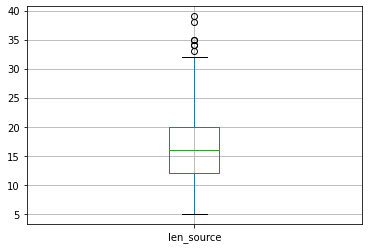

In [36]:
df_train['len_source'] = df_train['source'].str.split().map(lambda x:len(x))
df_train['len_target'] = df_train['target'].str.split().map(lambda x:len(x))
print('Source : Max length: {}, Min length: {}, Average Length :  {}'.format(max(df_train['len_source']),min(df_train['len_source']),df_train['len_source'].mean()))

# df_train['len_src'].hist()
# df['len_tar'].hist()
# df_train['len_src'].plot(kind='bar')
plot=df_train['len_source'].plot.box(grid=True)
fig = plot.get_figure()
fig.savefig("figures/src_len.png")

In [43]:
df_train[:1].values

array([['José Ortega y Gasset visited Husserl at Freiburg in 1934 .',
        '1934 besuchte José Ortega y Gasset Husserl in Freiburg .',
        'OK OK OK OK OK OK OK OK OK OK OK',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK',
        11, 10, 11, 10]], dtype=object)

In [39]:
#outliers
df_train[df_train.len_source > 35]

,source,target,src_tokens,tar_tokens,len_src,len_tar,len_source,len_target
761,"\ set Staff.midiInstrument = # "" string ensemb...","\ set Staff.midiInstrument = # "" string ensemb...",OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...,39,39,39,39
2922,It ’ s just not quite right still . ” He added...,Es war einfach nicht ganz richtig noch . Er fü...,OK OK OK OK OK OK OK OK OK BAD OK OK BAD BAD B...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...,38,33,38,33


Source : Max length: 39, Min length: 3, Average Length :  16.04885714285714


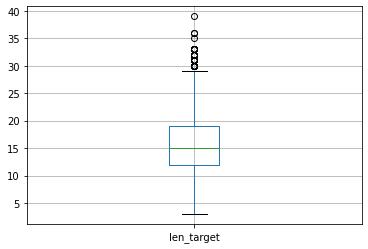

In [35]:
print('Source : Max length: {}, Min length: {}, Average Length :  {}'.format(max(df_train['len_target']),min(df_train['len_target']),df_train['len_target'].mean()))
plot = df_train['len_target'].plot.box(grid=True)
fig = plot.get_figure()
fig.savefig("output.png")

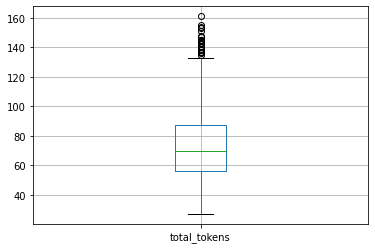

In [54]:
new_df_train = df_new_train.iloc[:,:-1].groupby('sentence_id')['words'].count().reset_index(name="total_tokens")
new_df_train # including token 
plot = new_df_train['total_tokens'].plot.box(grid=True) # after tokenization - including source and target
fig = plot.get_figure()
fig.savefig("figures/countofwords.png")

In [53]:
print('Tokens : Max length: {}, Min length: {}, Average Length :  {}'.format(max(new_df_train['total_tokens']),min(new_df_train['total_tokens']),new_df_train['total_tokens'].mean()))
df_temp = new_df_train[new_df_train.total_tokens >128]
len(df_temp[df_temp.sentence_id < 2000])

Tokens : Max length: 161, Min length: 27, Average Length :  72.93128571428572


16

In [32]:
df['source'] = df['source'].str.replace('\'','')
df[df['len_src']==8].values

array([['Musician Laura Marling hails originally from Hampshire .',
        'Die Musikerin Laura Marling stammt ursprünglich aus Hampshire .',
        'OK OK OK OK OK OK OK OK',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK', 8, 9],
       ['Knute Nelson in MNopedia , the Minnesota Encyclopedia',
        'Knute Nelson in MNopedia , der Minnesota Enzyklopädie',
        'OK OK OK OK OK OK BAD BAD',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK BAD OK BAD OK', 8, 8],
       ['Unicity and salvific universality of the Catholic Church',
        'Unicity und heilbringende Universalität der katholischen Kirche',
        'BAD OK OK OK OK OK OK OK',
        'OK BAD OK OK OK OK OK OK OK OK OK OK OK OK OK', 8, 7],
       ['Rachmaninoff toured between February and October 1918 .',
        'Rachmaninoff tourte zwischen Februar und Oktober 1918 .',
        'OK OK OK OK OK OK OK OK',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK', 8, 8],
       ['It subsequently und

In [28]:
print('Target : Max length: {}, Min length: {}, Average Length :  {}'.format(max(df['len_tar']),min(df['len_tar']),df['len_tar'].mean()))

df[df['len_tar']==35].values

Target : Max length: 37, Min length: 6, Average Length :  16.16


array([['On his return in 67 BC , he married Pompeia , a granddaughter of Sulla , whom he later divorced in 61 BC after her embroilment in the Bona Dea scandal .',
        'Nach seiner Rückkehr im Jahr 67 v. Chr. heiratete er Pompeia , eine Enkelin von Sulla , die er später im Jahre 61 v. Chr. nach ihrer Embroilment in der Bona Dea Skandal geschieden .',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD OK OK BAD OK OK OK OK OK BAD OK BAD BAD BAD BAD OK',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD BAD OK OK BAD OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD OK OK OK BAD OK BAD OK BAD OK BAD OK BAD OK OK OK',
        32, 35],
       ['One horse and rider , the " header , " lassos a running steer s horns , while the other horse and rider , the " heeler , " lassos the steer s two hind legs .',
        'Ein Pferd und Reiter , der " Header " , lassos eine laufende Lenkung Hörner , während das andere Pfer

In [8]:
loader_obj = createDataloaders(dataset_train,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
len(train_dataloader)

875

In [9]:
loader_obj = createDataloaders(dataset_eval,config.TRAIN_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()
len(val_dataloader)

125

In [10]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaForTokenClassification.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
#         self.out_tag = nn.Linear(768, 2)
    
    def forward(self, ids, attention_mask, labels):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                labels = labels,return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
#         tag = self.out_tag(bo_tag)  
        
#         loss_tag = loss_fn(outputs[1],labels,attention_mask)
        
#         return bo_tag,loss
        return outputs[0], outputs[1]
        

In [12]:


student = EntityModel()
meanteacher = EntityModel()




In [5]:
# PATH = '../models/training_data/model_xlmrobertatokenclassificationmodel_TrainData_earlystopping.bin'

# student.load_state_dict(torch.load(PATH))
# meanteacher.load_state_dict(torch.load(PATH))

# print(student)
# print(meanteacher)

In [13]:
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)

In [14]:
param_optimizer = list(student.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(dataset_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=3e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)

In [19]:
# for epoch in range(config.EPOCHS):
#             print(f'Epoch {epoch+1} of {config.EPOCHS}')
total_train_loss=0
total_val_loss_teacher = 0
total_val_loss_student = 0

for step, batch in enumerate(tqdm(train_dataloader, total = len(train_dataloader))):
    
    student.train()
    
    b_input_ids = batch[0].cuda()
    b_input_mask = batch[1].cuda()
    if step==874: # to change this, so that in self training all the labels are 0, manually doing for now! 
        labels_b = torch.from_numpy(np.full((5,256),0)).cuda()
    else:
        labels_b = torch.from_numpy(np.full((8,256),0)).cuda()
    
     # use confidence 
    optimizer.zero_grad()
    
    outputs = student(b_input_ids,attention_mask=b_input_mask,labels=labels_b)
    
    with torch.no_grad():
        mean_t_output = meanteacher(b_input_ids, 
            attention_mask=b_input_mask,labels=labels_b)
        
    const_loss = F.mse_loss(outputs[1], mean_t_output[1])
    const_loss.backward()
    total_train_loss = total_train_loss + const_loss.item()
    
    optimizer.step()
    scheduler.step()
    
    alpha = 0.995
    
    for (t_name, t_param), (s_name, s_param) in zip(meanteacher.named_parameters(), student.named_parameters()):
#                  param_new = s_param.data.to(t_param.device)
        param_new = s_param.data
        t_param.data.add_( (1-alpha)*(param_new-t_param.data) )
    
    if step % 50 == 0 and step!=0:
        print ('train loss : ', float(total_train_loss/step))



  6%|▌         | 51/875 [00:29<07:42,  1.78it/s]

train loss :  0.2868057399988174


 12%|█▏        | 101/875 [00:57<07:20,  1.76it/s]

train loss :  0.24330701753497125


 17%|█▋        | 151/875 [01:25<06:55,  1.74it/s]

train loss :  0.21765226925412814


 23%|██▎       | 201/875 [01:54<06:31,  1.72it/s]

train loss :  0.20112462677061557


 29%|██▊       | 251/875 [02:23<05:53,  1.76it/s]

train loss :  0.18873231148719788


 34%|███▍      | 301/875 [02:51<05:19,  1.80it/s]

train loss :  0.17811160723368327


 40%|████      | 351/875 [03:19<04:50,  1.80it/s]

train loss :  0.16841384584350244


 46%|████▌     | 401/875 [03:47<04:23,  1.80it/s]

train loss :  0.16284419071860612


 52%|█████▏    | 451/875 [04:14<03:55,  1.80it/s]

train loss :  0.1597311253597339


 57%|█████▋    | 501/875 [04:42<03:28,  1.79it/s]

train loss :  0.15522374395281077


 63%|██████▎   | 551/875 [05:10<03:00,  1.79it/s]

train loss :  0.14957325905561447


 69%|██████▊   | 601/875 [05:38<02:34,  1.78it/s]

train loss :  0.14376139448955655


 74%|███████▍  | 651/875 [06:06<02:06,  1.77it/s]

train loss :  0.13819561805862646


 80%|████████  | 701/875 [06:35<01:40,  1.74it/s]

train loss :  0.13321073691227606


 86%|████████▌ | 751/875 [07:04<01:11,  1.73it/s]

train loss :  0.1294568473448356


 92%|█████████▏| 801/875 [07:32<00:41,  1.78it/s]

train loss :  0.12666103387717156


 97%|█████████▋| 851/875 [08:00<00:13,  1.80it/s]

train loss :  0.12391007421647801


100%|██████████| 875/875 [08:13<00:00,  1.77it/s]


In [25]:
for  batch in tqdm(val_dataloader,total=len(val_dataloader)):
    b_input_ids_eval = batch[0].cuda()
    b_input_mask_eval = batch[1].cuda()
    b_labels_eval = batch[2].cuda()
    
    student.eval()
    meanteacher.eval()
    outputs_teacher_eval = meanteacher(b_input_ids_eval, 
            attention_mask=b_input_mask_eval,
            labels=b_labels_eval)
    
    loss_teacher = outputs_teacher_eval[0]
    total_val_loss_teacher=total_val_loss_teacher+loss_teacher.item()
    
    
    outputs_students_eval = student(b_input_ids_eval, 
            attention_mask=b_input_mask_eval,
            labels=b_labels_eval)
    
    loss_student = outputs_students_eval[0]
    total_val_loss_student=total_val_loss_student+loss_student.item()
    
print('teacher loss in prediction : ',total_val_loss_teacher/len(val_dataloader))
print('validation loss in prediction ;', total_val_loss_student/len(val_dataloader))
labels = b_labels_eval.view(-1) 
active_logits = outputs_teacher_eval[1].view(-1, 2)
flattened_predictions = torch.argmax(active_logits, axis=1)
active_accuracy = labels.view(-1) != -100
labels_tmp_teacher = torch.masked_select(labels, active_accuracy) 
pred_tmp_teacher = torch.masked_select(flattened_predictions, active_accuracy)
print('f1 score for class 0 teacher:',f1_score(labels_tmp_teacher.tolist(),pred_tmp_teacher.tolist(),average='binary',pos_label = 0))
print('f1 score for class 1 teacher:',f1_score(labels_tmp_teacher.tolist(),pred_tmp_teacher.tolist(),average='binary',pos_label = 1) )    
print('accuracy score teacher:',accuracy_score(labels_tmp_teacher.tolist(),pred_tmp_teacher.tolist()))
print('mcc score teacher:',matthews_corrcoef(labels_tmp_teacher.tolist(),pred_tmp_teacher.tolist()))
print(classification_report(labels_tmp_teacher.tolist(),pred_tmp_teacher.tolist()))
active_logits_student = outputs_students_eval[1].view(-1, 2)
flattened_predictions_student = torch.argmax(active_logits_student, axis=1)
active_accuracy_student = labels.view(-1) != -100
labels_tmp_student = torch.masked_select(labels, active_accuracy_student) 
pred_tmp_student = torch.masked_select(flattened_predictions_student, active_accuracy_student)
print('f1 score for class 0 student:',f1_score(labels_tmp_student.tolist(),pred_tmp_student.tolist(),average='binary',pos_label = 0))
print('f1 score for class 1 student:',f1_score(labels_tmp_student.tolist(),pred_tmp_student.tolist(),average='binary',pos_label = 1) )    
print('accuracy score student:',accuracy_score(labels_tmp_student.tolist(),pred_tmp_student.tolist()))
print('mcc score student:',matthews_corrcoef(labels_tmp_student.tolist(),pred_tmp_student.tolist()))
print(classification_report(labels_tmp_student.tolist(),pred_tmp_student.tolist()))

100%|██████████| 125/125 [00:26<00:00,  4.79it/s]

teacher loss in prediction :  4.173631928920746
validation loss in prediction ; 4.558810455799103
f1 score for class 0 teacher: 0.0
f1 score for class 1 teacher: 0.9465020576131687
accuracy score teacher: 0.8984375
mcc score teacher: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.90      1.00      0.95       460

    accuracy                           0.90       512
   macro avg       0.45      0.50      0.47       512
weighted avg       0.81      0.90      0.85       512

f1 score for class 0 student: 0.0
f1 score for class 1 student: 0.9465020576131687
accuracy score student: 0.8984375
mcc score student: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.90      1.00      0.95       460

    accuracy                           0.90       512
   macro avg       0.45      0.50      0.47       512
weighted avg       0.81


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

In [97]:
for  batch in tqdm(val_dataloader,total=len(val_dataloader)):
    b_input_ids_eval = batch[0].cuda()
    b_input_mask_eval = batch[1].cuda()
    b_labels_eval = batch[2].cuda()
    
    student.eval()
    
    outputs_teacher_eval = meanteacher(b_input_ids_eval, 
            attention_mask=b_input_mask_eval,
            labels=b_labels_eval)
    
    loss_teacher = outputs_teacher_eval[0]
    total_val_loss_teacher=total_val_loss_teacher+loss_teacher.item()
    
    
    outputs_students_eval = student(b_input_ids_eval, 
            attention_mask=b_input_mask_eval,
            labels=b_labels_eval)
    
    loss_student = outputs_students_eval[0]
    total_val_loss_student=total_val_loss_student+loss_student.item()
    
print('teacher loss in prediction : ',total_val_loss_teacher/len(val_dataloader))
print('validation loss in prediction ;', total_val_loss_student/len(val_dataloader))

  1%|          | 1/125 [00:00<00:55,  2.23it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.76 GiB total capacity; 13.72 GiB already allocated; 21.75 MiB free; 14.08 GiB reserved in total by PyTorch)

In [26]:
def mt_update(t_params, s_params, average="exponential", alpha=0.995, step=None):

    for (t_name, t_param), (s_name, s_param) in zip(t_params, s_params):
        if t_name != s_name:
            logger.error("t_name != s_name: {} {}".format(t_name, s_name))
            raise ValueError
        param_new = s_param.data.to(t_param.device)
        if average == "exponential":
            t_param.data.add_( (1-alpha)*(param_new-t_param.data) )
        elif average == "simple":
            virtual_decay = 1 / float(step)
            diff = (param_new - t_param.data) * virtual_decay
            t_param.data.add_(diff)

ZeroDivisionError: integer division or modulo by zero

In [ ]:
def train(args, model, mean_teacher, device, train_loader, test_loader, optimizer, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)

        ########################### CODE CHANGE HERE ######################################
        # forward pass with mean teacher
        # torch.no_grad() prevents gradients from being passed into mean teacher model
        with torch.no_grad():
            mean_t_output = mean_teacher(data)

        ########################### CODE CHANGE HERE ######################################
        # consistency loss (example with MSE, you can change)
        const_loss = F.mse_loss(output, mean_t_output)

        ########################### CODE CHANGE HERE ######################################
        # set the consistency weight (should schedule)
        weight = 0.5 # or 1 ?
#         loss = F.nll_loss(output, target) + weight*const_loss
        loss = weight*const_loss

        loss.backward()
        optimizer.step()

        ########################### CODE CHANGE HERE ######################################
        # update mean teacher, (should choose alpha somehow)
        # Use the true average until the exponential average is more correct
        alpha = 0.95
        for mean_param, param in zip(mean_teacher.parameters(), model.parameters()):
            mean_param.data.mul_(alpha).add_(1 - alpha, param.data)

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            test(args, model, device, test_loader)
            test(args, mean_teacher, device, test_loader)


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    model.train()



In [88]:
attention_mask_b = batch[1].cuda()
input_ids_b = batch[0].cuda()
labels_b = batch[2].cuda()

In [89]:
outputs_pred = student(input_ids_b, attention_mask = attention_mask_b,labels=labels_b)


In [76]:
outputs_pred

(tensor(4.7898, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[[-0.7516,  0.9833],
          [-2.1403,  2.1222],
          [-2.8458,  2.7934],
          ...,
          [-0.7905,  1.1940],
          [-0.7905,  1.1940],
          [-0.7905,  1.1940]],
 
         [[-0.7823,  1.2177],
          [-1.1539,  1.2850],
          [-1.0655,  1.0356],
          ...,
          [-0.9113,  1.4899],
          [-0.9113,  1.4899],
          [-0.9113,  1.4899]],
 
         [[-0.4266,  0.8377],
          [-0.6776,  1.1314],
          [ 1.1141, -1.2848],
          ...,
          [-0.4365,  1.0645],
          [-0.4365,  1.0645],
          [-0.4365,  1.0645]],
 
         ...,
 
         [[-0.6543,  1.1550],
          [-3.4233,  4.0548],
          [-2.9863,  3.1163],
          ...,
          [-0.7607,  1.3873],
          [-0.7607,  1.3873],
          [-0.7607,  1.3873]],
 
         [[-0.5817,  1.0901],
          [-3.0265,  3.6205],
          [-3.5847,  3.8294],
          ...,
          [-0.6869,  1.354

In [52]:
torch.tensor([-1]*len(batch[1][0]),dtype=torch.long)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [66]:
batch[2].shape

torch.Size([8, 256])

In [71]:
torch.from_numpy(np.full((8,256),0))

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [4]:
import torch

In [5]:
import torch.nn.functional as F
P = torch.Tensor([0.36, 0.48, 0.16])
Q = torch.Tensor([0.333, 0.333, 0.333])
out = F.kl_div(P, Q)
out

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(-0.4772)

In [90]:
len(train_dataloader)

875

In [91]:
for i,item in enumerate(train_dataloader):
    if i==874:
        print(item)

[tensor([[    0, 17779,   933,  ...,     1,     1,     1],
        [    0, 53295,    31,  ...,     1,     1,     1],
        [    0,  1529,    44,  ...,     1,     1,     1],
        [    0,  1529,    68,  ...,     1,     1,     1],
        [    0,  3183,   107,  ...,     1,     1,     1]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])]


In [94]:
item[0].shape

torch.Size([5, 256])